In [1]:
# Cell 1: Imports
import os
import glob
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import timm  # Pretrained models including EfficientNet
import glob


E:\PythonProject\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class UADFVFrameDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        for label, class_name in enumerate(['real', 'fake']):
            class_path = os.path.join(root_dir, class_name, 'frames')
            video_folders = glob.glob(os.path.join(class_path, '*'))

            for folder in video_folders:
                for img_path in glob.glob(os.path.join(folder, '*.png')):
                    self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

In [9]:
class DFTIMITFrameDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        for label, class_name in enumerate(['real', 'fake']):
            class_path = os.path.join(root_dir, class_name)
            video_folders = glob.glob(os.path.join(class_path, '*'))

            for folder in video_folders:
                for img_path in glob.glob(os.path.join(folder, '*.png')):
                    self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


In [10]:
import os
import cv2
import glob
from tqdm import tqdm

def extract_frames_from_videos(video_dir, output_dir, fps=1):
    os.makedirs(output_dir, exist_ok=True)
    video_files = glob.glob(os.path.join(video_dir, '*.mp4'))  # ✅ Correct usage

    for video_path in tqdm(video_files, desc="Extracting frames"):
        video_name = os.path.splitext(os.path.basename(video_path))[0]
        frame_output_dir = os.path.join(output_dir, video_name)
        os.makedirs(frame_output_dir, exist_ok=True)

        cap = cv2.VideoCapture(video_path)
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        frame_interval = int(frame_rate // fps) if fps < frame_rate else 1

        frame_count = 0
        saved_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            if frame_count % frame_interval == 0:
                out_path = os.path.join(frame_output_dir, f"{saved_count:04d}.png")
                cv2.imwrite(out_path, frame)
                saved_count += 1
            frame_count += 1
        cap.release()

In [11]:
class FaceForensicsDataset(Dataset):
    def __init__(self, root_dir, method='Deepfakes', compression='c40', transform=None):
        self.samples = []
        self.transform = transform

        # Real frames
        real_path = os.path.join(root_dir, 'original_sequences', 'youtube', compression, 'frames')
        real_video_dirs = glob.glob(os.path.join(real_path, '*'))
        for folder in real_video_dirs:
            for img_path in glob.glob(os.path.join(folder, '*.png')):
                self.samples.append((img_path, 0))

        # Fake frames
        fake_path = os.path.join(root_dir, 'manipulated_sequences', method, compression, 'frames')
        fake_video_dirs = glob.glob(os.path.join(fake_path, '*'))
        for folder in fake_video_dirs:
            for img_path in glob.glob(os.path.join(folder, '*.png')):
                self.samples.append((img_path, 1))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


In [12]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [13]:
import torch
import torch.nn as nn
from torchvision.models import resnet18

class PatchResnetLayer1(nn.Module):
    def __init__(self):
        super(PatchResnetLayer1, self).__init__()

        # Load ResNet-18 backbone
        resnet = resnet18(pretrained=True)

        # Optionally freeze ResNet layers
        for param in resnet.parameters():
            param.requires_grad = False

        # Patch ResNet initial layers + layer1
        self.resnet_stem = nn.Sequential(
            resnet.conv1,    # [B, 64, H/2, W/2]
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,  # [B, 64, H/4, W/4]
            resnet.layer1    # [B, 64, H/4, W/4]
        )

        # Remaining custom conv layers
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # [B, 16, H/8, W/8]
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(4, 4)  # [B, 16, H/32, W/32]
        )

        # Fully connected classifier
        self.fc = nn.Sequential(
            nn.Flatten(),                # [B, 16*8*8] if input is 256x256
            nn.Linear(16 * 8 * 8, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.resnet_stem(x)  # ResNet initial block and layer1
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.fc(x)
        return x.squeeze(1)


In [14]:
def train_model(dataset, name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PatchResnetLayer1().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.BCELoss()

    dataset_size = len(dataset)
    train_size = int(0.6 * dataset_size)
    val_size = int(0.2 * dataset_size)
    test_size = dataset_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = eval_transform
    test_dataset.dataset.transform = eval_transform

    train_loader = DataLoader(train_dataset, batch_size=75, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=75, shuffle=False)

    def train_epoch():
        model.train()
        total_loss = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.float().to(device)
            preds = model(images)
            loss = criterion(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)
        return total_loss / len(train_loader.dataset)

    for epoch in range(5):
        loss = train_epoch()
        print(f"Epoch {epoch+1}: Loss = {loss:.4f}")

    os.makedirs(f"saved_models/{name}", exist_ok=True)
    torch.save(model.state_dict(), f"saved_models/{name}/model.pth")
    return model, test_loader


In [15]:
import torch

if torch.cuda.is_available():
    print("✅ GPU is available:", torch.cuda.get_device_name(0))
else:
    print("❌ GPU is not available. Using CPU.")

✅ GPU is available: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [16]:
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            preds = model(images)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    auc = roc_auc_score(all_labels, all_preds)
    print(f"Test AUC: {auc:.4f}")

    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'Test AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve on Test Set')
    plt.legend()
    plt.grid(True)
    plt.show()

In [17]:
data = UADFVFrameDataset("E:/PythonProject/UADFV")
model, test_loader = train_model(data, "UADFV")

100%|██████████| 25/25 [00:15<00:00,  1.59it/s]


Epoch 1: Loss = 0.6666


100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


Epoch 2: Loss = 0.5265


100%|██████████| 25/25 [00:12<00:00,  1.95it/s]


Epoch 3: Loss = 0.3401


100%|██████████| 25/25 [00:12<00:00,  1.99it/s]


Epoch 4: Loss = 0.2049


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]

Epoch 5: Loss = 0.1365


Test AUC: 0.5046


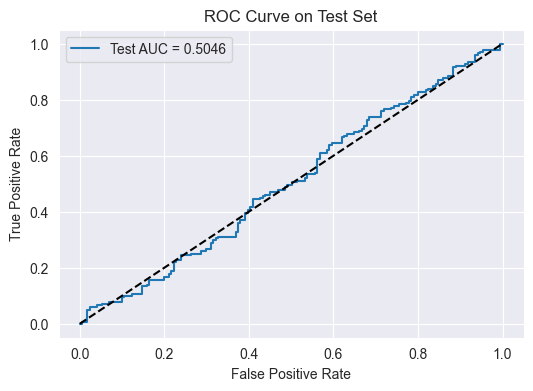

In [20]:
evaluate_model(model,test_loader)

In [21]:
data = FaceForensicsDataset(
    root_dir="E:/PythonProject/FaceForensics++",
    method='Deepfakes',
    compression='c40'
)
print("Loaded", len(data), "images")
model, test_loader = train_model(data, "FFPP_Deepfakes_c40")


Loaded 1752 images


E:\PythonProject\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\PythonProject\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 15/15 [00:40<00:00,  2.68s/it]


Epoch 1: Loss = 0.7008


100%|██████████| 15/15 [00:45<00:00,  3.02s/it]


Epoch 2: Loss = 0.6900


100%|██████████| 15/15 [00:43<00:00,  2.91s/it]


Epoch 3: Loss = 0.6854


100%|██████████| 15/15 [00:43<00:00,  2.93s/it]


Epoch 4: Loss = 0.6825


100%|██████████| 15/15 [00:42<00:00,  2.83s/it]

Epoch 5: Loss = 0.6796


Test AUC: 0.5286


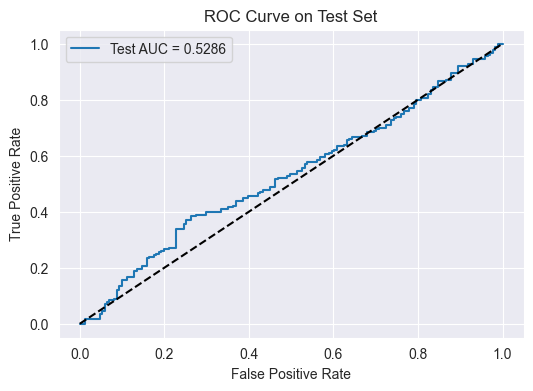

In [22]:
evaluate_model(model,test_loader)

In [23]:
data = FaceForensicsDataset(
    root_dir="E:/PythonProject/FaceForensics++",
    method='Face2Face',
    compression='c40'
)
print("Loaded", len(data), "images")
model, test_loader = train_model(data, "FFPP_Face2Face_c40")

Loaded 1807 images


E:\PythonProject\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\PythonProject\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 15/15 [00:45<00:00,  3.02s/it]


Epoch 1: Loss = 0.6870


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


Epoch 2: Loss = 0.6623


100%|██████████| 15/15 [00:30<00:00,  2.02s/it]


Epoch 3: Loss = 0.6435


100%|██████████| 15/15 [00:30<00:00,  2.04s/it]


Epoch 4: Loss = 0.6274


100%|██████████| 15/15 [00:30<00:00,  2.05s/it]

Epoch 5: Loss = 0.6104


Test AUC: 0.6138


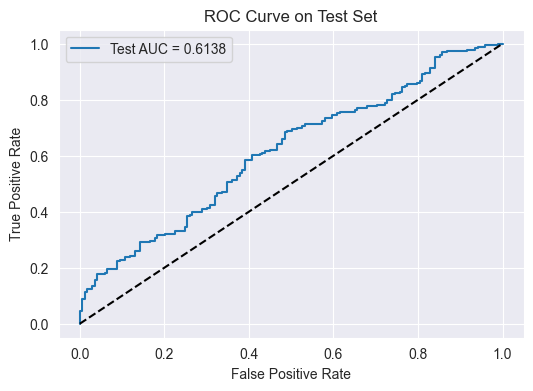

In [24]:
evaluate_model(model,test_loader)

In [25]:
data = FaceForensicsDataset(
    root_dir="E:/PythonProject/FaceForensics++",
    method='FaceShifter',
    compression='c40'
)
print("Loaded", len(data), "images")
model, test_loader = train_model(data, "FFPP_FaceShifter_c40")

Loaded 1758 images


E:\PythonProject\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\PythonProject\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Epoch 1: Loss = 0.6972


100%|██████████| 15/15 [00:43<00:00,  2.90s/it]


Epoch 2: Loss = 0.6831


100%|██████████| 15/15 [00:34<00:00,  2.28s/it]


Epoch 3: Loss = 0.6752


100%|██████████| 15/15 [00:43<00:00,  2.90s/it]


Epoch 4: Loss = 0.6709


100%|██████████| 15/15 [00:38<00:00,  2.54s/it]

Epoch 5: Loss = 0.6730


Test AUC: 0.4981


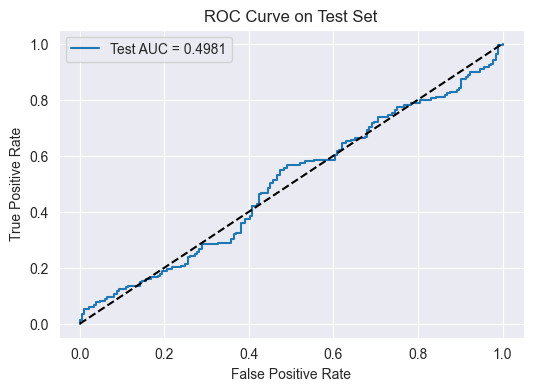

In [26]:
evaluate_model(model,test_loader)

In [27]:
data = FaceForensicsDataset(
    root_dir="E:/PythonProject/FaceForensics++",
    method='FaceSwap',
    compression='c40'
)
print("Loaded", len(data), "images")
model, test_loader = train_model(data, "FFPP_FaceShifter_c40")

Loaded 1601 images


E:\PythonProject\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\PythonProject\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 13/13 [00:39<00:00,  3.05s/it]


Epoch 1: Loss = 0.6898


100%|██████████| 13/13 [00:42<00:00,  3.29s/it]


Epoch 2: Loss = 0.6727


100%|██████████| 13/13 [00:44<00:00,  3.40s/it]


Epoch 3: Loss = 0.6610


100%|██████████| 13/13 [00:42<00:00,  3.30s/it]


Epoch 4: Loss = 0.6509


100%|██████████| 13/13 [00:42<00:00,  3.31s/it]

Epoch 5: Loss = 0.6412


Test AUC: 0.5721


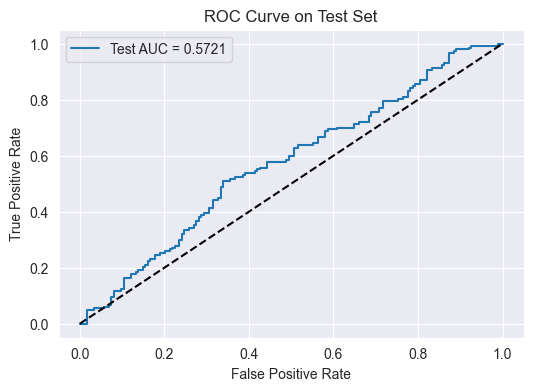

In [28]:
evaluate_model(model,test_loader)